# CDFS-SWIRE Master List Creation

## Preparation of VIDEO/VISTA/VIRCAM data


The catalogue comes from `dmu0_VISTA_VIDEO-private`.

There is an old public version of the catalogue but we are using the newer private version in the hope that it will be public by the time we publish the masterlist.

Filters: Z, Y, J, H, Ks 

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position (degrees);
- The stellarity;
- The magnitude for each band in apertude 3, which is 2 arcsec (rs548 presumes same for private catalogue).
- The “auto” magnitude is provided, we presume this is standard Sextractor units etc.

Yannick said the dates of observation for VIDEO are from 2009/11 to 2016/12. There is a paper from 2012 (Jarvis et al). So will use 2012.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

'en_GB'

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "video_ra"
DEC_COL = "video_dec"

## I - Column selection

In [6]:
# TODO: Check that the aperture magnitudes are aperture corrected.

imported_columns = OrderedDict({
        'ID':              'video_id', 
        'ALPHA_J2000':     'video_ra', 
        'DELTA_J2000':     'video_dec', 
        'J_CLASS_STAR':    'video_stellarity', 
        'Z_MAG_APER_3':    'm_ap_video_z', 
        'Z_MAGERR_APER_3': 'merr_ap_video_z', 
        'Z_MAG_AUTO':      'm_video_z', 
        'Z_MAGERR_AUTO':   'merr_video_z',
        'Z_FLUX_APER_3':   'f_ap_video_z', 
        'Z_FLUXERR_APER_3':'ferr_ap_video_z', 
        'Z_FLUX_AUTO':     'f_video_z', 
        'Z_FLUXERR_AUTO':  'ferr_video_z',
        'Y_MAG_APER_3':    'm_ap_video_y', 
        'Y_MAGERR_APER_3': 'merr_ap_video_y', 
        'Y_MAG_AUTO':      'm_video_y', 
        'Y_MAGERR_AUTO':   'merr_video_y',
        'Y_FLUX_APER_3':   'f_ap_video_y', 
        'Y_FLUXERR_APER_3':'ferr_ap_video_y', 
        'Y_FLUX_AUTO':     'f_video_y', 
        'Y_FLUXERR_AUTO':  'ferr_video_y',
        'J_MAG_APER_3':    'm_ap_video_j', 
        'J_MAGERR_APER_3': 'merr_ap_video_j', 
        'J_MAG_AUTO':      'm_video_j', 
        'J_MAGERR_AUTO':   'merr_video_j',
        'J_FLUX_APER_3':   'f_ap_video_j', 
        'J_FLUXERR_APER_3':'ferr_ap_video_j', 
        'J_FLUX_AUTO':     'f_video_j', 
        'J_FLUXERR_AUTO':  'ferr_video_j',
        'H_MAG_APER_3':    'm_ap_video_h', 
        'H_MAGERR_APER_3': 'merr_ap_video_h', 
        'H_MAG_AUTO':      'm_video_h', 
        'H_MAGERR_AUTO':   'merr_video_h',
        'H_FLUX_APER_3':   'f_ap_video_h', 
        'H_FLUXERR_APER_3':'ferr_ap_video_h', 
        'H_FLUX_AUTO':     'f_video_h', 
        'H_FLUXERR_AUTO':  'ferr_video_h',    
        'K_MAG_APER_3':    'm_ap_video_k', 
        'K_MAGERR_APER_3': 'merr_ap_video_k', 
        'K_MAG_AUTO':      'm_video_k', 
        'K_MAGERR_AUTO':   'merr_video_k',
        'K_FLUX_APER_3':   'f_ap_video_k', 
        'K_FLUXERR_APER_3':'ferr_ap_video_k', 
        'K_FLUX_AUTO':     'f_video_k', 
        'K_FLUXERR_AUTO':  'ferr_video_k'
})


catalogue = Table.read("../../dmu0/dmu0_VISTA-VIDEO-private/data/VIDEO-all_2017-02-12_fullcat_errfix_CDFS-SWIRE.fits"
                      )[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]
    
    
epoch = 2012

# Clean table metadata
catalogue.meta = None

In [7]:
# Correct wrong values.
# The catalogue contains negative fluxes and 99 in the associated magnitude. These
# values may be considered as upper limits but we don't want this information in the
# master list.  Also, some sources may have a very low signal to noise with the error
# on magnitude superior to 99.  In all these cases, we set the magnitude, the flux, and
# the associated errors to NaN.

band_names = [_[8:] for _ in catalogue.colnames if _.startswith("merr_ap_")]

for band in band_names:
    
    # Total fluxes and magnitudes
    mask = catalogue["m_{}".format(band)] > 90.
    mask &= catalogue["merr_{}".format(band)] > 90.
    mask &= catalogue["f_{}".format(band)] < 0.
    catalogue["m_{}".format(band)][mask] = np.nan
    catalogue["merr_{}".format(band)][mask] = np.nan
    catalogue["f_{}".format(band)][mask] = np.nan
    catalogue["ferr_{}".format(band)][mask] = np.nan
    
    # Aperture fluxes and magnitudes
    mask = catalogue["m_ap_{}".format(band)] > 90.
    mask &= catalogue["merr_ap_{}".format(band)] > 90.
    mask &= catalogue["f_ap_{}".format(band)] < 0.
    catalogue["m_ap_{}".format(band)][mask] = np.nan
    catalogue["merr_ap_{}".format(band)][mask] = np.nan
    catalogue["f_ap_{}".format(band)][mask] = np.nan
    catalogue["ferr_ap_{}".format(band)][mask] = np.nan
    
    # Adding the band-flag column
    catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag_{}".format(band)))


In [8]:
catalogue[:10].show_in_notebook()

idx,video_id,video_ra,video_dec,video_stellarity,m_ap_video_z,merr_ap_video_z,m_video_z,merr_video_z,f_ap_video_z,ferr_ap_video_z,f_video_z,ferr_video_z,m_ap_video_y,merr_ap_video_y,m_video_y,merr_video_y,f_ap_video_y,ferr_ap_video_y,f_video_y,ferr_video_y,m_ap_video_j,merr_ap_video_j,m_video_j,merr_video_j,f_ap_video_j,ferr_ap_video_j,f_video_j,ferr_video_j,m_ap_video_h,merr_ap_video_h,m_video_h,merr_video_h,f_ap_video_h,ferr_ap_video_h,f_video_h,ferr_video_h,m_ap_video_k,merr_ap_video_k,m_video_k,merr_video_k,f_ap_video_k,ferr_ap_video_k,f_video_k,ferr_video_k,flag_video_z,flag_video_y,flag_video_j,flag_video_h,flag_video_k
0,1000001,51.6895144683,-29.2340064259,0.961231,nan,nan,nan,nan,nan,nan,nan,nan,19.6489,0.0138815,19.5494,0.0151329,13817.9,176.672,15143.6,211.077,19.6279,0.0254966,19.5505,0.0270192,14087.4,330.83,15128.4,376.493,19.4104,0.0193537,19.4094,0.0234277,17211.7,306.815,17227.8,371.749,19.5918,0.0452992,19.4378,0.0453188,14563.6,607.643,16783.9,700.587,False,False,False,False,False
1,1000002,51.7010484072,-29.2341161444,0.645479,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,25.5284,2.53899,nan,nan,61.4675,143.746,22.1238,0.223169,22.772,0.285454,1414.05,290.663,778.413,204.662,21.0094,0.137603,21.8818,0.185034,3946.64,500.201,1767.11,301.166,False,False,False,False,False
2,1000003,51.8898615783,-29.2361107276,0.944543,27.657,5.34904,27.0248,5.95106,8.65328,42.633,15.4908,84.9099,21.4729,0.0402055,21.0561,0.046698,2575.33,95.3693,3780.68,162.614,21.2403,0.0660782,20.968,0.0715945,3190.54,194.183,4100.25,270.383,20.4756,0.0355692,20.1195,0.0402626,6452.73,211.401,8958.06,332.205,20.1166,0.0540781,19.8508,0.0552772,8981.51,447.364,11473.1,584.139,False,False,False,False,False
3,1000004,51.853580029,-29.2354194293,0.689547,27.5094,4.66903,29.0969,40.1266,9.91355,42.633,2.2974,84.9099,23.1546,0.143417,23.9821,0.364287,547.232,72.2874,255.364,85.6828,23.0954,0.249962,23.3499,0.29277,577.866,133.043,457.131,123.27,21.6704,0.0824213,22.7969,0.278287,2147.0,162.991,760.776,195.002,23.1453,0.541939,22.8499,0.396679,551.948,275.511,724.471,264.698,False,False,False,False,False
4,1000005,51.8860150497,-29.2356122466,0.711614,27.8279,6.2605,27.9576,14.0507,7.39346,42.633,6.561,84.9099,21.801,0.0399618,21.9542,0.0642644,1903.78,70.0731,1653.16,97.8535,22.2267,0.101281,22.4422,0.156096,1286.22,119.987,1054.64,151.63,21.4282,0.062309,21.5241,0.0967356,2683.56,154.011,2456.73,218.894,21.5286,0.110347,21.7755,0.177746,2446.55,248.659,1948.94,319.072,False,False,False,False,False
5,1000006,51.7777651536,-29.2344681682,0.591092,28.1199,8.1924,30.2863,120.007,5.64995,42.633,0.768179,84.9099,26.2743,2.4628,27.175,6.69129,30.9225,70.1444,13.4898,83.1389,nan,nan,25.2468,1.59335,nan,nan,79.669,116.921,22.9266,0.257481,25.4677,3.18308,675.095,160.103,64.9986,190.564,21.6558,0.130059,21.952,0.165533,2176.1,260.682,1656.51,252.563,False,False,False,False,False
6,1000007,51.9136213696,-29.235773692,0.649357,nan,nan,nan,nan,nan,nan,nan,nan,23.1538,0.312709,24.7923,0.919412,547.638,157.734,121.082,102.537,21.8762,0.16152,23.8974,0.54756,1776.31,264.262,276.095,139.246,nan,nan,nan,nan,nan,nan,nan,nan,21.0826,0.2287,21.4756,0.158754,3689.34,777.149,2568.94,375.636,False,False,False,False,False
7,1000008,51.8318880739,-29.2349719701,0.64305,25.8533,1.01575,26.2218,2.84057,45.5689,42.633,32.4536,84.9099,23.1053,0.128027,23.1728,0.187133,572.623,67.5243,538.112,92.7498,23.1945,0.242493,23.2581,0.304767,527.487,117.815,497.444,139.637,21.3375,0.0562675,21.4361,0.0852934,2917.42,151.198,2664.15,209.298,21.7918,0.137875,21.7922,0.167175,1919.87,243.807,1919.13,295.506,False,False,False,False,False
8,1000009,51.9471404014,-29.2360320189,0.0192727,nan,nan,nan,nan,nan,nan,nan,nan,23.8371,0.83132,23.1599,0.27562,291.841,223.463,544.535,138.238,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.7917,0.795893,21.7603,0.340352,1920.04,1407.52,1976.41,619.578,False,False,False,False,False
9,1000010,51.8122538425,-

## II - Correct z band fluxes and magnitudes

We discovered that the catalogue contains some wrong z magnitudes in the CDFS-SWIRE field. Strangely, Sextractor affected some magnitudes to sources which are not on the z image. Boris found a way to get rid of these magnitudes: all the wrong sources have a Z_MAGERR_AUTO to 0.

But we have to look at these sources in another catalogue because the VIDEO catalogue we use has been processed to correct for wrong error. We use the `video_id` column (which is unique within a field) to find the sources identified in the other catalogue and set their flux, magnitudes, and associated errors to NaN.

In [9]:
not_errfix_catalogue = Table.read("../../dmu0/dmu0_VISTA-VIDEO-private/data/VIDEO-cdfs_2017-02-12_fullcat.fits")

In [10]:
# Identifiers of the sources with bad z measurements
bad_z_sources_ids = not_errfix_catalogue['ID'][not_errfix_catalogue['Z_MAGERR_AUTO'] == 0]

# Mask of the bad z sources in our catalogue
bad_z_sources_mask = np.in1d(catalogue['video_id'], bad_z_sources_ids)

# Check that we caught all the bad sources
assert len(bad_z_sources_ids) == np.sum(bad_z_sources_mask)

In [11]:
del not_errfix_catalogue

In [12]:
# Set the z flux, magnitudes, and associated error of the bad z sources to NaN
catalogue['m_video_z'][bad_z_sources_mask] = np.nan
catalogue['merr_video_z'][bad_z_sources_mask] = np.nan
catalogue['f_video_z'][bad_z_sources_mask] = np.nan
catalogue['ferr_video_z'][bad_z_sources_mask] = np.nan
catalogue['m_ap_video_z'][bad_z_sources_mask] = np.nan
catalogue['merr_ap_video_z'][bad_z_sources_mask] = np.nan
catalogue['f_ap_video_z'][bad_z_sources_mask] = np.nan
catalogue['ferr_ap_video_z'][bad_z_sources_mask] = np.nan

## III - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [13]:
SORT_COLS = ['merr_ap_video_z', 'merr_ap_video_y', 'merr_ap_video_j', 'merr_ap_video_h', 'merr_ap_video_k']
FLAG_NAME = 'video_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 1073655 sources.
The cleaned catalogue has 1071323 sources (2332 removed).
The cleaned catalogue has 2319 sources flagged as having been cleaned


## IV - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [14]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_CDFS-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

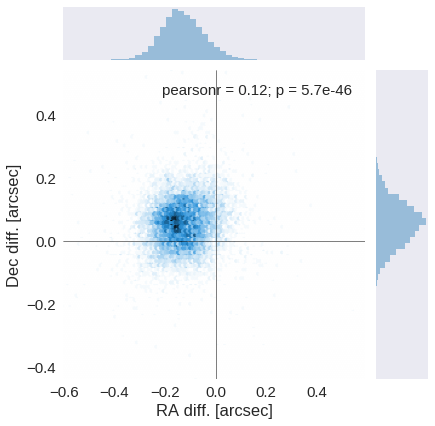

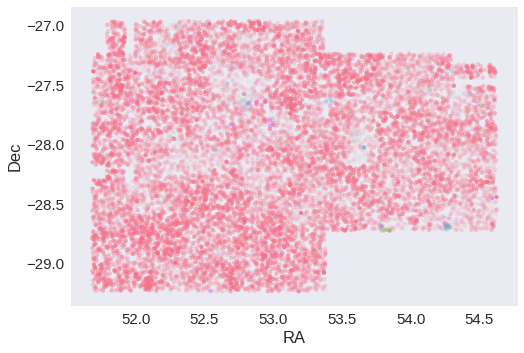

In [15]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [16]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.13464397878237833 arcsec
Dec correction: -0.05622936663485234 arcsec


In [17]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

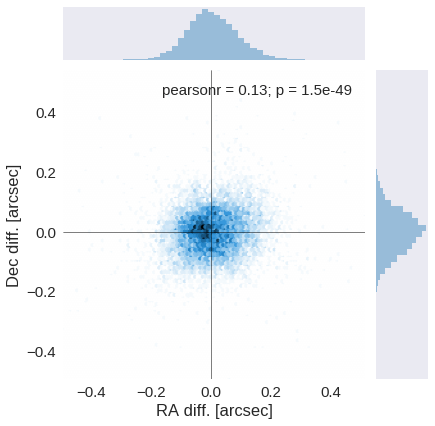

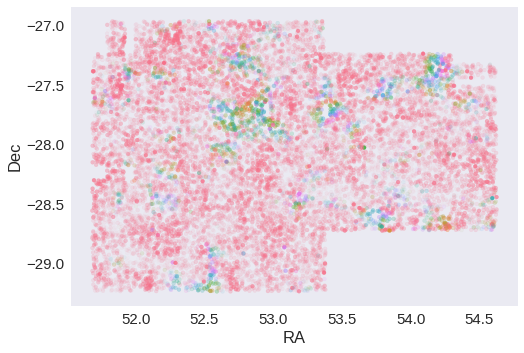

In [18]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## V - Flagging Gaia objects

In [19]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [20]:
GAIA_FLAG_NAME = "video_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

13687 sources flagged.


## VI - Saving to disk

In [21]:
catalogue.write("{}/VISTA-VIDEO.fits".format(OUT_DIR), overwrite=True)